<a href="https://colab.research.google.com/github/AngeloBongiorno/AML_2025_project4/blob/matteo/STEP_3A_PIDNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Dependency & DeepLab

## Upload .zip files

For this step you must have the zip files in your Drive into a folder called `AML_project`

In [1]:
!pip install torchmetrics
!pip install fvcore

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.9/960.9 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [2]:
from google.colab import drive
import os

!git clone -b vito --single-branch https://github.com/AngeloBongiorno/AML_2025_project4.git

!cp AML_2025_project4/utils.py .

drive.mount('/content/drive')

Cloning into 'AML_2025_project4'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 60 (delta 19), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (60/60), 4.05 MiB | 9.05 MiB/s, done.
Resolving deltas: 100% (19/19), done.
Mounted at /content/drive


In [3]:
import importlib
import utils  # Replace with the actual module name

importlib.reload(utils)

<module 'utils' from '/content/utils.py'>

In [4]:
import tqdm

from utils import get_loveDA

paths = get_loveDA(verbose=True)
print(paths)

TRAINING_PATH_URBAN = paths["training_urban"]
TRAINING_PATH_RURAL = paths["training_rural"]
VAL_PATH_URBAN = paths["validation_urban"]
VAL_PATH_RURAL = paths["validation_rural"]

Extracting training...
training extracted!
Extracting validation...
validation extracted!
Extraction check completed!
{'training_urban': '/content/dataset/Train/Urban', 'training_rural': '/content/dataset/Train/Rural', 'validation_urban': '/content/dataset/Val/Urban', 'validation_rural': '/content/dataset/Val/Rural'}


In [5]:
SEM_CLASSES = [
    'background',
    'building',
    'road',
    'water',
    'barren',
    'forest',
    'agriculture'
]

NUM_CLASSES = len(SEM_CLASSES)
sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(SEM_CLASSES)}

RESIZE = (512, 512)

BATCH_SIZE = 16

EPOCHS = 20

SEED = 42

STEP_SIZE = 5

GAMMA = 0.1

LR = 0.01

# Define and instantiate

### Define PIDnet

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

BatchNorm2d = nn.BatchNorm2d
bn_mom = 0.1
algc = False

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, no_relu=False):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1 = BatchNorm2d(planes, momentum=bn_mom)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               padding=1, bias=False)
        self.bn2 = BatchNorm2d(planes, momentum=bn_mom)
        self.downsample = downsample
        self.stride = stride
        self.no_relu = no_relu

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual

        if self.no_relu:
            return out
        else:
            return self.relu(out)

class Bottleneck(nn.Module):
    expansion = 2

    def __init__(self, inplanes, planes, stride=1, downsample=None, no_relu=True):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = BatchNorm2d(planes, momentum=bn_mom)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = BatchNorm2d(planes, momentum=bn_mom)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1,
                               bias=False)
        self.bn3 = BatchNorm2d(planes * self.expansion, momentum=bn_mom)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        self.no_relu = no_relu

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        if self.no_relu:
            return out
        else:
            return self.relu(out)

class segmenthead(nn.Module):

    def __init__(self, inplanes, interplanes, outplanes, scale_factor=None):
        super(segmenthead, self).__init__()
        self.bn1 = BatchNorm2d(inplanes, momentum=bn_mom)
        self.conv1 = nn.Conv2d(inplanes, interplanes, kernel_size=3, padding=1, bias=False)
        self.bn2 = BatchNorm2d(interplanes, momentum=bn_mom)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(interplanes, outplanes, kernel_size=1, padding=0, bias=True)
        self.scale_factor = scale_factor

    def forward(self, x):

        x = self.conv1(self.relu(self.bn1(x)))
        out = self.conv2(self.relu(self.bn2(x)))

        if self.scale_factor is not None:
            height = x.shape[-2] * self.scale_factor
            width = x.shape[-1] * self.scale_factor
            out = F.interpolate(out,
                        size=[height, width],
                        mode='bilinear', align_corners=algc)

        return out

class DAPPM(nn.Module):
    def __init__(self, inplanes, branch_planes, outplanes, BatchNorm=nn.BatchNorm2d):
        super(DAPPM, self).__init__()
        bn_mom = 0.1
        self.scale1 = nn.Sequential(nn.AvgPool2d(kernel_size=5, stride=2, padding=2),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale2 = nn.Sequential(nn.AvgPool2d(kernel_size=9, stride=4, padding=4),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale3 = nn.Sequential(nn.AvgPool2d(kernel_size=17, stride=8, padding=8),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale4 = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale0 = nn.Sequential(
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.process1 = nn.Sequential(
                                    BatchNorm(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.process2 = nn.Sequential(
                                    BatchNorm(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.process3 = nn.Sequential(
                                    BatchNorm(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.process4 = nn.Sequential(
                                    BatchNorm(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.compression = nn.Sequential(
                                    BatchNorm(branch_planes * 5, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes * 5, outplanes, kernel_size=1, bias=False),
                                    )
        self.shortcut = nn.Sequential(
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, outplanes, kernel_size=1, bias=False),
                                    )

    def forward(self, x):
        width = x.shape[-1]
        height = x.shape[-2]
        x_list = []

        x_list.append(self.scale0(x))
        x_list.append(self.process1((F.interpolate(self.scale1(x),
                        size=[height, width],
                        mode='bilinear', align_corners=algc)+x_list[0])))
        x_list.append((self.process2((F.interpolate(self.scale2(x),
                        size=[height, width],
                        mode='bilinear', align_corners=algc)+x_list[1]))))
        x_list.append(self.process3((F.interpolate(self.scale3(x),
                        size=[height, width],
                        mode='bilinear', align_corners=algc)+x_list[2])))
        x_list.append(self.process4((F.interpolate(self.scale4(x),
                        size=[height, width],
                        mode='bilinear', align_corners=algc)+x_list[3])))

        out = self.compression(torch.cat(x_list, 1)) + self.shortcut(x)
        return out

class PAPPM(nn.Module):
    def __init__(self, inplanes, branch_planes, outplanes, BatchNorm=nn.BatchNorm2d):
        super(PAPPM, self).__init__()
        bn_mom = 0.1
        self.scale1 = nn.Sequential(nn.AvgPool2d(kernel_size=5, stride=2, padding=2),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale2 = nn.Sequential(nn.AvgPool2d(kernel_size=9, stride=4, padding=4),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale3 = nn.Sequential(nn.AvgPool2d(kernel_size=17, stride=8, padding=8),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale4 = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )

        self.scale0 = nn.Sequential(
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )

        self.scale_process = nn.Sequential(
                                    BatchNorm(branch_planes*4, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes*4, branch_planes*4, kernel_size=3, padding=1, groups=4, bias=False),
                                    )


        self.compression = nn.Sequential(
                                    BatchNorm(branch_planes * 5, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes * 5, outplanes, kernel_size=1, bias=False),
                                    )

        self.shortcut = nn.Sequential(
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, outplanes, kernel_size=1, bias=False),
                                    )


    def forward(self, x):
        width = x.shape[-1]
        height = x.shape[-2]
        scale_list = []

        x_ = self.scale0(x)
        scale_list.append(F.interpolate(self.scale1(x), size=[height, width],
                        mode='bilinear', align_corners=algc)+x_)
        scale_list.append(F.interpolate(self.scale2(x), size=[height, width],
                        mode='bilinear', align_corners=algc)+x_)
        scale_list.append(F.interpolate(self.scale3(x), size=[height, width],
                        mode='bilinear', align_corners=algc)+x_)
        scale_list.append(F.interpolate(self.scale4(x), size=[height, width],
                        mode='bilinear', align_corners=algc)+x_)

        scale_out = self.scale_process(torch.cat(scale_list, 1))

        out = self.compression(torch.cat([x_,scale_out], 1)) + self.shortcut(x)
        return out


class PagFM(nn.Module):
    def __init__(self, in_channels, mid_channels, after_relu=False, with_channel=False, BatchNorm=nn.BatchNorm2d):
        super(PagFM, self).__init__()
        self.with_channel = with_channel
        self.after_relu = after_relu
        self.f_x = nn.Sequential(
                                nn.Conv2d(in_channels, mid_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(mid_channels)
                                )
        self.f_y = nn.Sequential(
                                nn.Conv2d(in_channels, mid_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(mid_channels)
                                )
        if with_channel:
            self.up = nn.Sequential(
                                    nn.Conv2d(mid_channels, in_channels,
                                              kernel_size=1, bias=False),
                                    BatchNorm(in_channels)
                                   )
        if after_relu:
            self.relu = nn.ReLU(inplace=True)

    def forward(self, x, y):
        input_size = x.size()
        if self.after_relu:
            y = self.relu(y)
            x = self.relu(x)

        y_q = self.f_y(y)
        y_q = F.interpolate(y_q, size=[input_size[2], input_size[3]],
                            mode='bilinear', align_corners=False)
        x_k = self.f_x(x)

        if self.with_channel:
            sim_map = torch.sigmoid(self.up(x_k * y_q))
        else:
            sim_map = torch.sigmoid(torch.sum(x_k * y_q, dim=1).unsqueeze(1))

        y = F.interpolate(y, size=[input_size[2], input_size[3]],
                            mode='bilinear', align_corners=False)
        x = (1-sim_map)*x + sim_map*y

        return x

class Light_Bag(nn.Module):
    def __init__(self, in_channels, out_channels, BatchNorm=nn.BatchNorm2d):
        super(Light_Bag, self).__init__()
        self.conv_p = nn.Sequential(
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(out_channels)
                                )
        self.conv_i = nn.Sequential(
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(out_channels)
                                )

    def forward(self, p, i, d):
        edge_att = torch.sigmoid(d)

        p_add = self.conv_p((1-edge_att)*i + p)
        i_add = self.conv_i(i + edge_att*p)

        return p_add + i_add


class DDFMv2(nn.Module):
    def __init__(self, in_channels, out_channels, BatchNorm=nn.BatchNorm2d):
        super(DDFMv2, self).__init__()
        self.conv_p = nn.Sequential(
                                BatchNorm(in_channels),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(out_channels)
                                )
        self.conv_i = nn.Sequential(
                                BatchNorm(in_channels),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(out_channels)
                                )

    def forward(self, p, i, d):
        edge_att = torch.sigmoid(d)

        p_add = self.conv_p((1-edge_att)*i + p)
        i_add = self.conv_i(i + edge_att*p)

        return p_add + i_add

class Bag(nn.Module):
    def __init__(self, in_channels, out_channels, BatchNorm=nn.BatchNorm2d):
        super(Bag, self).__init__()

        self.conv = nn.Sequential(
                                BatchNorm(in_channels),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=3, padding=1, bias=False)
                                )


    def forward(self, p, i, d):
        edge_att = torch.sigmoid(d)
        return self.conv(edge_att*p + (1-edge_att)*i)

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import logging

BatchNorm2d = nn.BatchNorm2d
bn_mom = 0.1
algc = False



class PIDNet(nn.Module):

    def __init__(self, m=2, n=3, num_classes=19, planes=64, ppm_planes=96, head_planes=128, augment=True):
        super(PIDNet, self).__init__()
        self.augment = augment

        # I Branch
        self.conv1 =  nn.Sequential(
                          nn.Conv2d(3,planes,kernel_size=3, stride=2, padding=1),
                          BatchNorm2d(planes, momentum=bn_mom),
                          nn.ReLU(inplace=True),
                          nn.Conv2d(planes,planes,kernel_size=3, stride=2, padding=1),
                          BatchNorm2d(planes, momentum=bn_mom),
                          nn.ReLU(inplace=True),
                      )

        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(BasicBlock, planes, planes, m)
        self.layer2 = self._make_layer(BasicBlock, planes, planes * 2, m, stride=2)
        self.layer3 = self._make_layer(BasicBlock, planes * 2, planes * 4, n, stride=2)
        self.layer4 = self._make_layer(BasicBlock, planes * 4, planes * 8, n, stride=2)
        self.layer5 =  self._make_layer(Bottleneck, planes * 8, planes * 8, 2, stride=2)

        # P Branch
        self.compression3 = nn.Sequential(
                                          nn.Conv2d(planes * 4, planes * 2, kernel_size=1, bias=False),
                                          BatchNorm2d(planes * 2, momentum=bn_mom),
                                          )

        self.compression4 = nn.Sequential(
                                          nn.Conv2d(planes * 8, planes * 2, kernel_size=1, bias=False),
                                          BatchNorm2d(planes * 2, momentum=bn_mom),
                                          )
        self.pag3 = PagFM(planes * 2, planes)
        self.pag4 = PagFM(planes * 2, planes)

        self.layer3_ = self._make_layer(BasicBlock, planes * 2, planes * 2, m)
        self.layer4_ = self._make_layer(BasicBlock, planes * 2, planes * 2, m)
        self.layer5_ = self._make_layer(Bottleneck, planes * 2, planes * 2, 1)

        # D Branch
        if m == 2:
            self.layer3_d = self._make_single_layer(BasicBlock, planes * 2, planes)
            self.layer4_d = self._make_layer(Bottleneck, planes, planes, 1)
            self.diff3 = nn.Sequential(
                                        nn.Conv2d(planes * 4, planes, kernel_size=3, padding=1, bias=False),
                                        BatchNorm2d(planes, momentum=bn_mom),
                                        )
            self.diff4 = nn.Sequential(
                                     nn.Conv2d(planes * 8, planes * 2, kernel_size=3, padding=1, bias=False),
                                     BatchNorm2d(planes * 2, momentum=bn_mom),
                                     )
            self.spp = PAPPM(planes * 16, ppm_planes, planes * 4)
            self.dfm = Light_Bag(planes * 4, planes * 4)
        else:
            self.layer3_d = self._make_single_layer(BasicBlock, planes * 2, planes * 2)
            self.layer4_d = self._make_single_layer(BasicBlock, planes * 2, planes * 2)
            self.diff3 = nn.Sequential(
                                        nn.Conv2d(planes * 4, planes * 2, kernel_size=3, padding=1, bias=False),
                                        BatchNorm2d(planes * 2, momentum=bn_mom),
                                        )
            self.diff4 = nn.Sequential(
                                     nn.Conv2d(planes * 8, planes * 2, kernel_size=3, padding=1, bias=False),
                                     BatchNorm2d(planes * 2, momentum=bn_mom),
                                     )
            self.spp = DAPPM(planes * 16, ppm_planes, planes * 4)
            self.dfm = Bag(planes * 4, planes * 4)

        self.layer5_d = self._make_layer(Bottleneck, planes * 2, planes * 2, 1)

        # Prediction Head
        if self.augment:
            self.seghead_p = segmenthead(planes * 2, head_planes, num_classes)
            self.seghead_d = segmenthead(planes * 2, planes, 1)

        self.final_layer = segmenthead(planes * 4, head_planes, num_classes)


        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


    def _make_layer(self, block, inplanes, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, momentum=bn_mom),
            )

        layers = []
        layers.append(block(inplanes, planes, stride, downsample))
        inplanes = planes * block.expansion
        for i in range(1, blocks):
            if i == (blocks-1):
                layers.append(block(inplanes, planes, stride=1, no_relu=True))
            else:
                layers.append(block(inplanes, planes, stride=1, no_relu=False))

        return nn.Sequential(*layers)

    def _make_single_layer(self, block, inplanes, planes, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, momentum=bn_mom),
            )

        layer = block(inplanes, planes, stride, downsample, no_relu=True)

        return layer

    def forward(self, x):

        width_output = x.shape[-1] // 8
        height_output = x.shape[-2] // 8

        x = self.conv1(x)
        x = self.layer1(x)
        x = self.relu(self.layer2(self.relu(x)))
        x_ = self.layer3_(x)
        x_d = self.layer3_d(x)

        x = self.relu(self.layer3(x))
        x_ = self.pag3(x_, self.compression3(x))
        x_d = x_d + F.interpolate(
                        self.diff3(x),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)
        if self.augment:
            temp_p = x_

        x = self.relu(self.layer4(x))
        x_ = self.layer4_(self.relu(x_))
        x_d = self.layer4_d(self.relu(x_d))

        x_ = self.pag4(x_, self.compression4(x))
        x_d = x_d + F.interpolate(
                        self.diff4(x),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)
        if self.augment:
            temp_d = x_d

        x_ = self.layer5_(self.relu(x_))
        x_d = self.layer5_d(self.relu(x_d))
        x = F.interpolate(
                        self.spp(self.layer5(x)),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)

        x_ = self.final_layer(self.dfm(x_, x, x_d))

        if self.augment:
            x_extra_p = self.seghead_p(temp_p)
            x_extra_d = self.seghead_d(temp_d)
            return [x_extra_p, x_, x_extra_d]
        else:
            return x_

def get_seg_model(cfg, imgnet_pretrained):

    if 's' in cfg.MODEL.NAME:
        model = PIDNet(m=2, n=3, num_classes=cfg.DATASET.NUM_CLASSES, planes=32, ppm_planes=96, head_planes=128, augment=True)
    elif 'm' in cfg.MODEL.NAME:
        model = PIDNet(m=2, n=3, num_classes=cfg.DATASET.NUM_CLASSES, planes=64, ppm_planes=96, head_planes=128, augment=True)
    else:
        model = PIDNet(m=3, n=4, num_classes=cfg.DATASET.NUM_CLASSES, planes=64, ppm_planes=112, head_planes=256, augment=True)

    if imgnet_pretrained:
        pretrained_state = torch.load(cfg.MODEL.PRETRAINED, map_location='cpu')['state_dict']
        model_dict = model.state_dict()
        pretrained_state = {k: v for k, v in pretrained_state.items() if (k in model_dict and v.shape == model_dict[k].shape)}
        model_dict.update(pretrained_state)
        msg = 'Loaded {} parameters!'.format(len(pretrained_state))
        logging.info('Attention!!!')
        logging.info(msg)
        logging.info('Over!!!')
        model.load_state_dict(model_dict, strict = False)
    else:
        pretrained_dict = torch.load(cfg.MODEL.PRETRAINED, map_location='cpu')
        if 'state_dict' in pretrained_dict:
            pretrained_dict = pretrained_dict['state_dict']
        model_dict = model.state_dict()
        pretrained_dict = {k[6:]: v for k, v in pretrained_dict.items() if (k[6:] in model_dict and v.shape == model_dict[k[6:]].shape)}
        msg = 'Loaded {} parameters!'.format(len(pretrained_dict))
        logging.info('Attention!!!')
        logging.info(msg)
        logging.info('Over!!!')
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict, strict = False)

    return model

def get_pred_model(name, num_classes):

    if 's' in name:
        model = PIDNet(m=2, n=3, num_classes=num_classes, planes=32, ppm_planes=96, head_planes=128, augment=False)
    elif 'm' in name:
        model = PIDNet(m=2, n=3, num_classes=num_classes, planes=64, ppm_planes=96, head_planes=128, augment=False)
    else:
        model = PIDNet(m=3, n=4, num_classes=num_classes, planes=64, ppm_planes=112, head_planes=256, augment=False)

    return model

### Instantiate model

In [8]:
import gdown
#import requests
#import tarfile

#if (os.path.exists("./pidnet.py") == False):
#  url = "https://raw.githubusercontent.com/XuJiacong/PIDNet/refs/heads/main/models/pidnet.py"
#  output_file = "./pidnet.py"
#  response = requests.get(url)
#  response.raise_for_status()
#  with open(output_file, "w", encoding="utf-8") as f:
#    f.write(response.text)
#
#  print("Pidnet model downloaded")
#
#if (os.path.exists("./model_utils.py") == False):
#  url = "https://raw.githubusercontent.com/XuJiacong/PIDNet/refs/heads/main/models/model_utils.py"
#  output_file = "./model_utils.py"
#  response = requests.get(url)
#  response.raise_for_status()
#  with open(output_file, "w", encoding="utf-8") as f:
#    f.write(response.text)
#
#  print("Pidnet utils downloaded")


if (os.path.exists("./PIDNet_S_ImageNet.pth.tar") == False):
  url = "https://drive.google.com/uc?id=1hIBp_8maRr60-B3PF0NVtaA6TYBvO4y-"
  output = "./"
  gdown.download(url, output, quiet=False)

  print("imagenet-pretrained pidnet weights downloaded")


class Config:
  class MODEL:
      NAME = 'pidnet_s'
      PRETRAINED = 'PIDNet_S_ImageNet.pth.tar'
  class DATASET:
      NUM_CLASSES = NUM_CLASSES

cfg = Config()

model = get_seg_model(cfg, imgnet_pretrained=True)
next(model.parameters()).device


Downloading...
From: https://drive.google.com/uc?id=1hIBp_8maRr60-B3PF0NVtaA6TYBvO4y-
To: /content/PIDNet_S_ImageNet.pth.tar
100%|██████████| 38.1M/38.1M [00:00<00:00, 119MB/s] 


imagenet-pretrained pidnet weights downloaded


device(type='cpu')

# Dataset & dataloader

## Dataset definition

In [9]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2

class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, target_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.target_transform = target_transform
        #self.boundary_transform = boundary_transform
        self.image_filenames = sorted(os.listdir(image_dir))
        self.mask_filenames = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_filenames[idx])

        image = Image.open(img_path).convert("RGB")  # Assicura che sia RGB
        mask = Image.open(mask_path).convert("L")  # Converti la maschera in scala di grigi (1 canale)

        if self.transform:
            image = self.transform(image)

        if self.target_transform:
          mask = self.target_transform(mask)

        mask_np = np.array(mask)

        #mask_grayscale = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        edge = cv2.Canny(mask_np, 0.1, 0.2)

        kernel = np.ones((3, 3), np.uint8)  # Kernel for dilation

        edge = edge[6:-6, 6:-6]
        edge = np.pad(edge, ((6,6),(6,6)), mode='constant')
        boundaries = cv2.dilate(edge, kernel, iterations=1)  # Dilate edges
        boundaries = (boundaries > 50) * 1.0 # boundaries matrix is float with 1.0 or 0.0

        #if self.target_transform:
        #  boundaries = self.boundary_transform(boundaries)

        mask = torch.as_tensor(np.array(mask), dtype=torch.int64) - 1

        boundaries_tensor = torch.as_tensor(boundaries, dtype=torch.float32)

        return image, mask, boundaries_tensor  # Return (image, mask) pair

## Dataset instantiation

In [10]:
# Define transformations for images & masks
image_transform = transforms.Compose([
    transforms.Resize(RESIZE, interpolation=Image.BILINEAR),  # Resize images to 256x256
    transforms.ToTensor(),  # Convert image to tensor
])

mask_transform = transforms.Compose([
    transforms.Resize(RESIZE, interpolation=Image.NEAREST),  # Resize masks to 256x256
])

#boundary_transform = transforms.Compose([
#    transforms.Resize(RESIZE, interpolation=Image.NEAREST),  # Resize masks to 256x256
#])

# Create dataset objects
DOMAIN_SHIFT = True

train_dataset = SegmentationDataset(TRAINING_PATH_URBAN + "/images_png", TRAINING_PATH_URBAN + "/masks_png",
                                      transform=image_transform, target_transform=mask_transform)
if not DOMAIN_SHIFT:
  val_dataset = SegmentationDataset(VAL_PATH_URBAN + "/images_png", VAL_PATH_URBAN + "/masks_png",
                                    transform=image_transform, target_transform= mask_transform)
else:
  val_dataset = SegmentationDataset(VAL_PATH_RURAL + "/images_png", VAL_PATH_RURAL + "/masks_png",
                                    transform=image_transform, target_transform= mask_transform)

## Loader instantiation

In [11]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


torch.Size([16, 3, 512, 512]) torch.Size([16, 512, 512]) torch.Size([16, 512, 512])


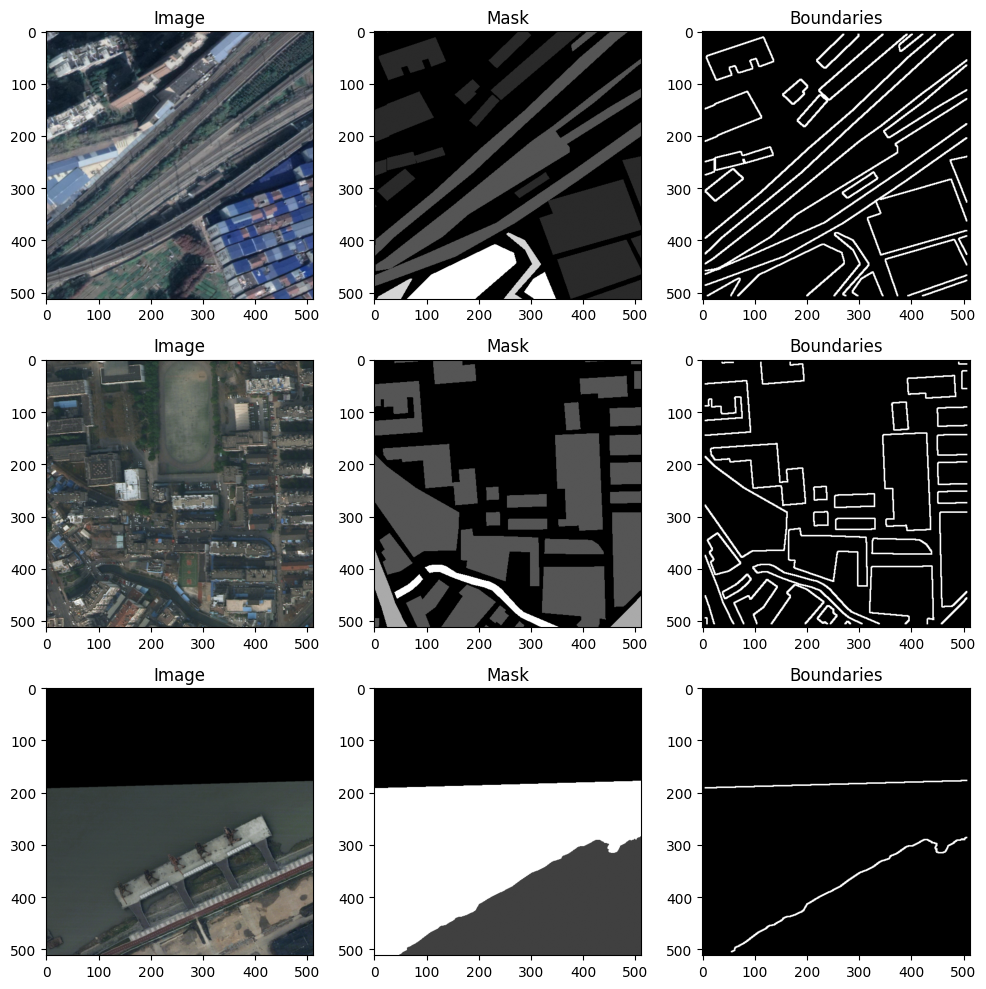

In [12]:
from utils import show
from matplotlib import pyplot as plt

print(next(iter(train_loader))[0].shape, next(iter(train_loader))[1].shape, next(iter(train_loader))[2].shape)

batch = next(iter(train_loader))  # (images, masks, boundaries)
images, masks, boundaries = batch  # Unpack the batch

fig, axes = plt.subplots(3, 3, figsize=(10, 10))  # 3 images, each with RGB, mask, and boundary

for i in range(3):  # Show first 3 images
    axes[i, 0].imshow(images[i].permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
    axes[i, 0].set_title("Image")

    axes[i, 1].imshow(masks[i].cpu().numpy(), cmap="gray")  # Show mask
    axes[i, 1].set_title("Mask")

    axes[i, 2].imshow(boundaries[i].cpu().numpy(), cmap="gray")  # Show boundaries
    axes[i, 2].set_title("Boundaries")

plt.tight_layout()
plt.show()

# Training Phase

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
print(device);

cuda


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# 1. Extra Semantic Loss (Classica CrossEntropy Loss)
class CrossEntropyLoss(nn.Module):
    def __init__(self, weight=None):
        super(CrossEntropyLoss, self).__init__()
        self.loss = nn.CrossEntropyLoss(weight=weight, ignore_index=-1)

    def forward(self, pred, target):
        return self.loss(pred, target)

# 2. Weighted Binary Cross Entropy per i bordi
class WeightedBinaryCrossEntropy(nn.Module):
    def __init__(self, pos_weight=20.0):  # Peso λ1 sui bordi
        super(WeightedBinaryCrossEntropy, self).__init__()
        self.loss = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight))

    def forward(self, pred, target):
        return self.loss(pred, target)

# 3. Boundary-Aware CrossEntropy Loss
class BoundaryAwareCELoss(nn.Module):
    def __init__(self, weight=None):
        super(BoundaryAwareCELoss, self).__init__()
        self.loss = nn.CrossEntropyLoss(weight=weight, ignore_index=-1)

    def forward(self, pred, target, boundary_mask):
        ce_loss = self.loss(pred, target)
        return torch.mean(ce_loss * boundary_mask)  # Pesa i bordi

# 4. BAS-Loss per segmentazione e detection dei bordi
class BASLoss(nn.Module):
    def __init__(self, threshold=0.8):
        super(BASLoss, self).__init__()
        self.threshold = threshold

    def forward(self, boundary_head, pred, target):
        boundary_mask = (boundary_head > self.threshold).float()  # Maschera bordi
        log_probs = F.log_softmax(pred, dim=1)

        # Reshape per compatibilità
        batch_size, num_classes, H, W = log_probs.shape
        log_probs = log_probs.permute(0, 2, 3, 1).reshape(-1, num_classes)  # [B*H*W, num_classes]
        target = target.reshape(-1)  # [B*H*W]
        boundary_mask = boundary_mask.reshape(-1)  # [B*H*W]

        # Applica la perdita solo ai bordi
        loss = -torch.sum(boundary_mask * log_probs[torch.arange(target.shape[0]), target])

        # Normalizza rispetto al numero di pixel nei bordi (evita divisioni per 0)
        return loss / (boundary_mask.sum() + 1e-6)

# 5. PIDNet Loss Totale
class PIDNetLoss(nn.Module):
    def __init__(self, lambda_0=0.4, lambda_1=20, lambda_2=1, lambda_3=1, threshold=0.8):
        super(PIDNetLoss, self).__init__()
        self.ce_loss = CrossEntropyLoss()
        self.wbce_loss = WeightedBinaryCrossEntropy(pos_weight=lambda_1)
        self.boundary_ce_loss = BoundaryAwareCELoss()
        self.bas_loss = BASLoss(threshold)

        self.lambda_0 = lambda_0
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        self.lambda_3 = lambda_3

    def forward(self, pred, target, boundary_head, boundary_mask):
        """
        pred: output principale (B, C, H, W)
        target: ground truth segmentazione (B, H, W)
        boundary_head: predizione dei bordi (B, 1, H, W)
        boundary_mask: ground truth dei bordi (B, 1, H, W)
        """
        L0 = self.ce_loss(pred, target)  # Extra Semantic Loss
        L1 = self.wbce_loss(boundary_head, boundary_mask.unsqueeze(1))  # Weighted BCE
        L2 = self.boundary_ce_loss(pred, target, boundary_mask)  # Boundary-Aware CE
        L3 = self.bas_loss(boundary_head, pred, target)  # BAS-Loss

        loss = (self.lambda_0 * L0 +
                self.lambda_1 * L1 +
                self.lambda_2 * L2 +
                self.lambda_3 * L3)

        return loss


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CrossEntropyLoss(nn.Module):
    def __init__(self, weight=None):
        super(CrossEntropyLoss, self).__init__()
        self.loss = nn.CrossEntropyLoss(weight=weight, ignore_index=-1)

    def forward(self, pred, target):
        return self.loss(pred, target)

class BoundaryAwareCELoss(nn.Module):
    def __init__(self, weight=None):
        super(BoundaryAwareCELoss, self).__init__()
        self.loss = nn.CrossEntropyLoss(weight=weight, ignore_index=-1)

    def forward(self, pred, target, boundary_mask):
        loss = self.loss(pred, target)
        return torch.mean(loss * boundary_mask)  # Penalizza maggiormente i bordi

class BASLoss(nn.Module):
    def __init__(self, threshold=0.8):
        super(BASLoss, self).__init__()
        self.threshold = threshold

    def forward(self, boundary_head, pred, target):
        boundary_mask = (boundary_head > self.threshold).float()  # Maschera dei bordi
        log_probs = F.log_softmax(pred, dim=1)  # Calcola log-softmax

        # Appiattisci tutto per evitare errori di broadcasting
        batch_size, num_classes, H, W = log_probs.shape
        log_probs = log_probs.permute(0, 2, 3, 1).reshape(-1, num_classes)  # [B*H*W, num_classes]
        target = target.reshape(-1)  # [B*H*W]
        boundary_mask = boundary_mask.reshape(-1)  # [B*H*W]

        # Ora target ha shape [B*H*W] e log_probs ha [B*H*W, num_classes]
        loss = -torch.sum(boundary_mask * log_probs[torch.arange(target.shape[0]), target])

        return loss / (boundary_mask.sum() + 1e-6)  # Evita divisioni per zero


class PIDNetLoss(nn.Module):
    def __init__(self, lambda_0=0.4, lambda_1=20, lambda_2=1, lambda_3=1, threshold=0.8):
        super(PIDNetLoss, self).__init__()
        self.ce_loss = CrossEntropyLoss()
        self.boundary_ce_loss = BoundaryAwareCELoss()
        self.bas_loss = BASLoss(threshold)

        self.lambda_0 = lambda_0
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        self.lambda_3 = lambda_3

    def forward(self, pred, target, boundary_head, boundary_mask):
        L0 = self.ce_loss(pred, target)
        L1 = self.ce_loss(pred, target)  # Stessa loss con pesi diversi
        L2 = self.boundary_ce_loss(pred, target, boundary_mask)
        L3 = self.bas_loss(boundary_head, pred, target)

        loss = (self.lambda_0 * L0 +
                self.lambda_1 * L1 +
                self.lambda_2 * L2 +
                self.lambda_3 * L3)

        return loss


In [16]:
batch = next(iter(train_loader))  # (images, masks, boundaries)
X, y, boundaries = batch  # Unpack the batch
X = X.to(device)
y = y.to(device)

print("X =", X.shape)
print("y =", y.shape)
print("boundary =", boundaries.shape)

# Output del modello
outputs = model(X)  # PIDNet può restituire [x_extra_p, x_, x_extra_d] se augment=True

# Upscale trough bilinear interpolation -> riporto le dimensioni dell'output a quelli originali
# Quindi passiamo da 64 x 64 a 512 x 512
h, w = boundaries.size(1), boundaries.size(2)
ph, pw = outputs[0].size(2), outputs[0].size(3)
if ph != h or pw != w:
    for i in range(len(outputs)):
        outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear', align_corners=True)

pred_p, pred_main, boundary_head = outputs  # P, I, D branches

#print("outputs[0] =", outputs[0].shape) # pred_p
print("outputs[1] =", outputs[1].shape) # pred_main
print("outputs[2] =", outputs[2].shape) # Ramo D (boundary_head)

preds = torch.argmax(pred_main, dim=1)
print("preds =", preds.shape)


X = torch.Size([16, 3, 512, 512])
y = torch.Size([16, 512, 512])
boundary = torch.Size([16, 512, 512])
outputs[1] = torch.Size([16, 7, 512, 512])
outputs[2] = torch.Size([16, 1, 512, 512])
preds = torch.Size([16, 512, 512])


In [20]:
from tqdm import tqdm
import torch
from torchmetrics.segmentation import MeanIoU

os.makedirs("/content/drive/MyDrive/AML_project/checkpoints", exist_ok=True)

torch.manual_seed(SEED)

num_classes = 7  # Cambia in base al tuo dataset
miou_classes = MeanIoU(num_classes=num_classes, per_class=True).to(device)
miou_overall = MeanIoU(num_classes=num_classes).to(device)
loss_fn = PIDNetLoss()

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0

    total_train_samples = 0

    batch_pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{EPOCHS}", ncols=100)

    for batch, (X, y, boundary_mask) in batch_pbar:
        X = X.to(device)
        y = y.to(device)
        boundary_mask = boundary_mask.to(device)

        # Output del modello
        outputs = model(X)  # PIDNet può restituire [x_extra_p, x_, x_extra_d] se augment=True

        # Upscale trough bilinear interpolation -> riporto le dimensioni dell'output a quelli originali
        # Quindi passiamo da 64 x 64 della rete a 512 x 512
        h, w = boundary_mask.size(1), boundary_mask.size(2)
        ph, pw = outputs[0].size(2), outputs[0].size(3)
        if ph != h or pw != w:
            for i in range(len(outputs)):
                outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear', align_corners=True)

        if model.augment:
            pred_p, pred_main, boundary_head = outputs  # P, I, D branches
        else:
            pred_main = outputs
            boundary_head = None  # Nessuna branch D se augment=False

        # Calcolo della loss
        loss = loss_fn(pred_main, y, boundary_head, boundary_mask)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_samples += X.size(0)

        train_loss += loss.item()
        batch_pbar.set_postfix(loss=loss.item())

    #avg_train_loss = train_loss / len(train_loader)

    #total_samples = sum(len(batch[0]) for batch in train_loader)
    avg_train_loss = train_loss / total_train_samples


    print(f"Epoch {epoch+1}/{EPOCHS} - Training Loss: {avg_train_loss}")


    # **Validazione**
    model.eval()
    val_loss = 0
    miou_classes.reset()
    miou_overall.reset()

    import torch.nn.functional as F

    total_val_samples = 0

    with torch.inference_mode():
        for X_val, y_val, boundary_mask in val_loader:
            X_val = X_val.to(device)
            y_val = y_val.to(device)
            boundary_mask = boundary_mask.to(device)

            # Output del modello
            outputs = model(X_val)

            ## Upscale trough bilinear interpolation
            h, w = boundary_mask.size(1), boundary_mask.size(2)
            ph, pw = outputs[0].size(2), outputs[0].size(3)
            if ph != h or pw != w:
                for i in range(len(outputs)):
                    outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear', align_corners=True)

            if model.augment:
                pred_p, pred_main, boundary_head = outputs
            else:
                pred_main = outputs
                boundary_head = None


            # Correzione per gestire la classe ignorata (-1)
            y_val_fixed = y_val + 1  # Shift per evitare problemi con -1
            target_one_hot = F.one_hot(y_val_fixed, num_classes=num_classes+1).permute(0, 3, 1, 2)

            # Creazione della maschera per escludere la classe ignorata
            valid_mask = (y_val != -1).unsqueeze(1)  # Shape: (batch_size, 1, H, W)

            # Escludiamo la classe ignorata senza alterare gli indici
            target_one_hot = target_one_hot[:, 1:] * valid_mask

            # Predizioni binarie per mIoU
            pred_miou = F.one_hot(pred_main.argmax(dim=1), num_classes=num_classes).permute(0, 3, 1, 2)
            pred_miou = pred_miou * valid_mask  # Applichiamo la stessa maschera

            # Aggiornamento delle metriche
            miou_classes.update(preds=pred_miou, target=target_one_hot)
            miou_overall.update(preds=pred_main.argmax(dim=1), target=y_val)

            # Calcola la loss
            loss = loss_fn(pred_main, y_val, boundary_head, boundary_mask)

            val_loss += loss.item()
            total_val_samples += X_val.size(0)


    avg_val_loss = val_loss / total_val_samples


    miou_per_class = miou_classes.compute()  # Returns a tensor with per-class IoU
    miou = miou_overall.compute()  # Returns a tensor with per-class IoU
    miou_per_class_str = ", ".join([f"Class {i}: {iou:.4f}" for i, iou in enumerate(miou_per_class)])
    #print(f"Epoch {epoch+1}/{EPOCHS} - Validation Loss: {avg_val_loss} - mIoU: {miou_score:.4f}")
    print(f"Epoch {epoch+1}/{EPOCHS} - Validation Loss: {avg_val_loss} - mIoU: {miou} - mIoU per class {miou_per_class_str}")

    if epoch % 5 == 0:
      print(scheduler.get_last_lr())


    ## steps the scheduler
    scheduler.step()


Epoch 1/20: 100%|████████████████████████████████████████| 73/73 [01:21<00:00,  1.12s/it, loss=29.2]

Epoch 1/20 - Training Loss: 1.7172361476198612


Epoch 1/20 - Validation Loss: 3.0350318916382326 - mIoU: 0.15180054306983948 - mIoU per class Class 0: 0.3039, Class 1: 0.1092, Class 2: 0.0181, Class 3: 0.0072, Class 4: 0.0209, Class 5: 0.0101, Class 6: 0.0000
[0.01]


Epoch 2/20: 100%|████████████████████████████████████████| 73/73 [01:21<00:00,  1.11s/it, loss=17.6]

Epoch 2/20 - Training Loss: 1.4950552201188558


Epoch 2/20 - Validation Loss: 3.1141901631509104 - mIoU: 0.05633297562599182 - mIoU per class Class 0: 0.4300, Class 1: 0.0693, Class 2: 0.0289, Class 3: 0.0897, Class 4: 0.0000, Class 5: 0.0001, Class 6: 0.0002


Epoch 3/20: 100%|████████████████████████████████████████| 73/73 [01:23<00:00,  1.14s/it, loss=20.8]

Epoch 3/20 - Training Loss: 1.3078600758087264


Epoch 3/20 - Validation Loss: 3.100155670796671 - mIoU: 0.15602624416351318 - mIoU per class Class 0: 0.3706, Class 1: 0.0673, Class 2: 0.0213, Class 3: 0.1406, Class 4: 0.0021, Class 5: 0.0260, Class 6: 0.0065


Epoch 4/20: 100%|████████████████████████████████████████| 73/73 [01:19<00:00,  1.09s/it, loss=21.1]

Epoch 4/20 - Training Loss: 1.2533743876486914


Epoch 4/20 - Validation Loss: 2.901646387192511 - mIoU: 0.19278556108474731 - mIoU per class Class 0: 0.4011, Class 1: 0.1201, Class 2: 0.0530, Class 3: 0.2402, Class 4: 0.0168, Class 5: 0.0181, Class 6: 0.0404


Epoch 5/20: 100%|██████████████████████████████████████████| 73/73 [01:22<00:00,  1.13s/it, loss=15]

Epoch 5/20 - Training Loss: 1.1344842646773712


Epoch 5/20 - Validation Loss: 3.500758413345583 - mIoU: 0.10695192962884903 - mIoU per class Class 0: 0.4137, Class 1: 0.0951, Class 2: 0.0082, Class 3: 0.1451, Class 4: 0.0134, Class 5: 0.0122, Class 6: 0.0000


Epoch 6/20: 100%|████████████████████████████████████████| 73/73 [01:19<00:00,  1.09s/it, loss=22.5]

Epoch 6/20 - Training Loss: 1.1351040638854346


Epoch 6/20 - Validation Loss: 2.8159034290621356 - mIoU: 0.221978560090065 - mIoU per class Class 0: 0.3918, Class 1: 0.1142, Class 2: 0.0564, Class 3: 0.2368, Class 4: 0.0185, Class 5: 0.0605, Class 6: 0.0611
[0.001]


Epoch 7/20: 100%|████████████████████████████████████████| 73/73 [01:20<00:00,  1.10s/it, loss=31.4]

Epoch 7/20 - Training Loss: 1.0788000174459702


Epoch 7/20 - Validation Loss: 11.434836691425692 - mIoU: 0.1481839418411255 - mIoU per class Class 0: 0.3338, Class 1: 0.0573, Class 2: 0.0303, Class 3: 0.1791, Class 4: 0.0168, Class 5: 0.0376, Class 6: 0.0104


Epoch 8/20: 100%|████████████████████████████████████████| 73/73 [01:20<00:00,  1.11s/it, loss=18.8]

Epoch 8/20 - Training Loss: 1.057945743151602


Epoch 8/20 - Validation Loss: 2.810758706062071 - mIoU: 0.18675068020820618 - mIoU per class Class 0: 0.4165, Class 1: 0.1194, Class 2: 0.0670, Class 3: 0.2373, Class 4: 0.0141, Class 5: 0.0437, Class 6: 0.0645


Epoch 9/20: 100%|████████████████████████████████████████| 73/73 [01:20<00:00,  1.10s/it, loss=18.7]

Epoch 9/20 - Training Loss: 1.0301732678726883


Epoch 9/20 - Validation Loss: 4.211758909686919 - mIoU: 0.2039581537246704 - mIoU per class Class 0: 0.3769, Class 1: 0.1333, Class 2: 0.0648, Class 3: 0.2219, Class 4: 0.0143, Class 5: 0.0571, Class 6: 0.0738


Epoch 10/20: 100%|███████████████████████████████████████| 73/73 [01:19<00:00,  1.09s/it, loss=16.5]

Epoch 10/20 - Training Loss: 0.9999775003809417


Epoch 10/20 - Validation Loss: 6.3969009672441794 - mIoU: 0.1920759230852127 - mIoU per class Class 0: 0.3832, Class 1: 0.1256, Class 2: 0.0634, Class 3: 0.2144, Class 4: 0.0169, Class 5: 0.0510, Class 6: 0.0782


Epoch 11/20: 100%|███████████████████████████████████████| 73/73 [01:19<00:00,  1.09s/it, loss=18.8]

Epoch 11/20 - Training Loss: 0.9890496202818663


Epoch 11/20 - Validation Loss: 4.163829882298747 - mIoU: 0.19938574731349945 - mIoU per class Class 0: 0.4055, Class 1: 0.1353, Class 2: 0.0675, Class 3: 0.2197, Class 4: 0.0169, Class 5: 0.0488, Class 6: 0.0826
[0.0001]


Epoch 12/20: 100%|███████████████████████████████████████| 73/73 [01:20<00:00,  1.10s/it, loss=14.7]

Epoch 12/20 - Training Loss: 0.9880990214826326


Epoch 12/20 - Validation Loss: 4.007144820305609 - mIoU: 0.18480007350444794 - mIoU per class Class 0: 0.4126, Class 1: 0.1328, Class 2: 0.0659, Class 3: 0.2169, Class 4: 0.0163, Class 5: 0.0431, Class 6: 0.1002


Epoch 13/20: 100%|███████████████████████████████████████| 73/73 [01:18<00:00,  1.08s/it, loss=16.1]

Epoch 13/20 - Training Loss: 0.988833473627955


Epoch 13/20 - Validation Loss: 5.301052245401567 - mIoU: 0.20164082944393158 - mIoU per class Class 0: 0.4067, Class 1: 0.1310, Class 2: 0.0614, Class 3: 0.2003, Class 4: 0.0180, Class 5: 0.0500, Class 6: 0.0806


Epoch 14/20: 100%|███████████████████████████████████████| 73/73 [01:19<00:00,  1.10s/it, loss=14.6]

Epoch 14/20 - Training Loss: 0.9733050876010249


Epoch 14/20 - Validation Loss: 4.031461229247432 - mIoU: 0.22518716752529144 - mIoU per class Class 0: 0.4079, Class 1: 0.1344, Class 2: 0.0656, Class 3: 0.2246, Class 4: 0.0176, Class 5: 0.0453, Class 6: 0.0784


Epoch 15/20: 100%|███████████████████████████████████████| 73/73 [01:18<00:00,  1.08s/it, loss=16.1]

Epoch 15/20 - Training Loss: 0.9809729920951553


Epoch 15/20 - Validation Loss: 4.992468032144731 - mIoU: 0.18371041119098663 - mIoU per class Class 0: 0.4048, Class 1: 0.1324, Class 2: 0.0614, Class 3: 0.2153, Class 4: 0.0147, Class 5: 0.0396, Class 6: 0.0736


Epoch 16/20: 100%|█████████████████████████████████████████| 73/73 [01:18<00:00,  1.08s/it, loss=16]

Epoch 16/20 - Training Loss: 0.9711399944595812


Epoch 16/20 - Validation Loss: 4.880263836153092 - mIoU: 0.19964712858200073 - mIoU per class Class 0: 0.3818, Class 1: 0.1348, Class 2: 0.0688, Class 3: 0.2217, Class 4: 0.0160, Class 5: 0.0537, Class 6: 0.0898
[1e-05]


Epoch 17/20: 100%|███████████████████████████████████████| 73/73 [01:18<00:00,  1.08s/it, loss=17.7]


Epoch 17/20 - Training Loss: 0.9809827821064986
Epoch 17/20 - Validation Loss: 5.86748569819235 - mIoU: 0.23457594215869904 - mIoU per class Class 0: 0.3899, Class 1: 0.1333, Class 2: 0.0648, Class 3: 0.2171, Class 4: 0.0165, Class 5: 0.0527, Class 6: 0.0844


Epoch 18/20: 100%|███████████████████████████████████████| 73/73 [01:17<00:00,  1.06s/it, loss=16.1]

Epoch 18/20 - Training Loss: 0.972794414804056


Epoch 18/20 - Validation Loss: 5.060597521643484 - mIoU: 0.21377289295196533 - mIoU per class Class 0: 0.3819, Class 1: 0.1352, Class 2: 0.0671, Class 3: 0.2201, Class 4: 0.0202, Class 5: 0.0555, Class 6: 0.1002


Epoch 19/20: 100%|███████████████████████████████████████| 73/73 [01:19<00:00,  1.09s/it, loss=20.9]

Epoch 19/20 - Training Loss: 0.9755518147689661


Epoch 19/20 - Validation Loss: 5.982299770078352 - mIoU: 0.21018165349960327 - mIoU per class Class 0: 0.3778, Class 1: 0.1310, Class 2: 0.0610, Class 3: 0.2178, Class 4: 0.0143, Class 5: 0.0541, Class 6: 0.0934


Epoch 20/20: 100%|███████████████████████████████████████| 73/73 [01:18<00:00,  1.07s/it, loss=20.1]

Epoch 20/20 - Training Loss: 0.9814754563631896


Epoch 20/20 - Validation Loss: 5.7885221012177 - mIoU: 0.203668013215065 - mIoU per class Class 0: 0.3984, Class 1: 0.1308, Class 2: 0.0658, Class 3: 0.2180, Class 4: 0.0174, Class 5: 0.0464, Class 6: 0.0937


In [23]:
# **Validazione modificata Teo**
model.eval()
val_loss = 0
miou_classes.reset()
miou_overall.reset()

import torch.nn.functional as F

total_val_samples = 0

with torch.inference_mode():
    for X_val, y_val, boundary_mask in val_loader:
        X_val = X_val.to(device)
        y_val = y_val.to(device)
        boundary_mask = boundary_mask.to(device)

        # Output del modello
        outputs = model(X_val)

        ## Upscale through bilinear interpolation
        h, w = boundary_mask.size(1), boundary_mask.size(2)
        ph, pw = outputs[0].size(2), outputs[0].size(3)
        if ph != h or pw != w:
            for i in range(len(outputs)):
                outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear', align_corners=True)

        if model.augment:
            pred_p, pred_main, boundary_head = outputs
        else:
            pred_main = outputs
            boundary_head = None

        # Correzione per gestire la classe ignorata (-1)
        y_val_fixed = y_val + 1  # Shift per evitare problemi con -1
        target_one_hot = F.one_hot(y_val_fixed, num_classes=num_classes+1).permute(0, 3, 1, 2)

        # Creazione della maschera per escludere la classe ignorata
        valid_mask = (y_val != -1).unsqueeze(1)  # Shape: (batch_size, 1, H, W)

        # Escludiamo la classe ignorata senza alterare gli indici
        target_one_hot = target_one_hot[:, 1:] * valid_mask

        # Predizioni binarie per mIoU
        pred_miou = F.one_hot(pred_main.argmax(dim=1), num_classes=num_classes).permute(0, 3, 1, 2)
        pred_miou = pred_miou * valid_mask  # Applichiamo la stessa maschera

        # Aggiornamento delle metriche
        miou_classes.update(preds=pred_miou, target=target_one_hot)
        miou_overall.update(preds=pred_main.argmax(dim=1), target=y_val)

        # Calcola la loss
        loss = loss_fn(pred_main, y_val, boundary_head, boundary_mask)

        val_loss += loss.item()
        total_val_samples += X_val.size(0)

# Calcolo della loss media
avg_val_loss = val_loss / total_val_samples

# Calcolo delle metriche IoU
miou_per_class = miou_classes.compute()  # mIoU per classe
miou = miou_overall.compute()  # mIoU complessiva
miou_per_class_str = ", ".join([f"Class {i}: {iou:.4f}" for i, iou in enumerate(miou_per_class)])

# Stampa dei risultati
print(f"Epoch {epoch+1}/{EPOCHS} - Validation Loss: {avg_val_loss} - mIoU: {miou} - mIoU per class {miou_per_class_str}")


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 20/20 - Validation Loss: 5.78852198008568 - mIoU: 0.203668013215065 - mIoU per class Class 0: 0.3984, Class 1: 0.1308, Class 2: 0.0658, Class 3: 0.2180, Class 4: 0.0174, Class 5: 0.0464, Class 6: 0.0937


### Salvataggio del modello su drive

In [21]:
checkpoint_path = f"/content/drive/MyDrive/AML_project/checkpoints/model_PIDNET_urban.pth"
torch.save(model.state_dict(), checkpoint_path)
print(f"Modello salvato: {checkpoint_path}")

Modello salvato: /content/drive/MyDrive/AML_project/checkpoints/model_PIDNET_urban.pth


## Criterions

*********


FLOPs: 6.317 GFLOPs
Average inference latency is 0.020 seconds.


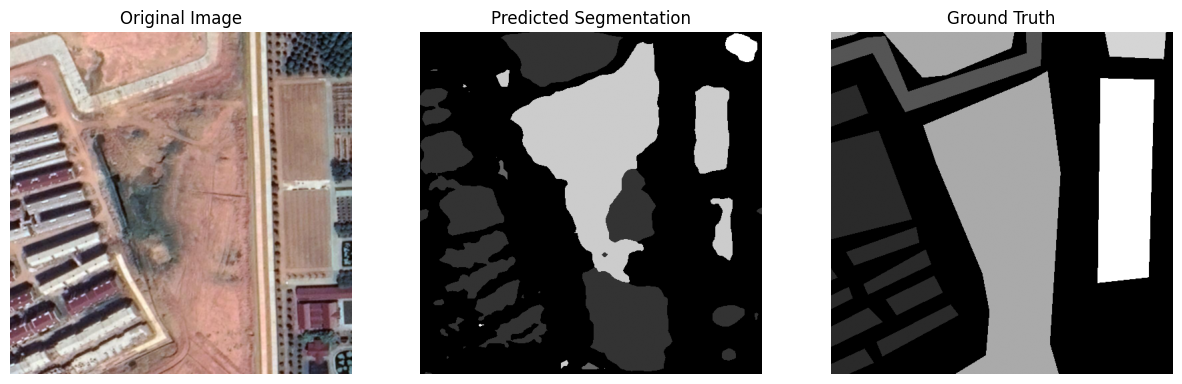

Params: 7.718 M


In [36]:
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from fvcore.nn import FlopCountAnalysis
import torch.nn.functional as F
import random

model.eval()  # Set model to evaluation mode

with torch.inference_mode():
    # Prendi un'immagine random dal validation set
    random_index = random.randint(0, len(val_dataset) - 1)
    X, y, boundary_mask = val_dataset[random_index]

    X = X.to(device).unsqueeze(dim=0)  # Aggiunge la dimensione batch
    y = y.to(device).unsqueeze(dim=0)
    boundary_mask = boundary_mask.to(device).unsqueeze(dim=0)

    start = timer()
    outputs = model(X)
    end = timer()

    latency = end - start

    ## Upscale trough bilinear interpolation
    h, w = boundary_mask.size(1), boundary_mask.size(2)
    ph, pw = outputs[0].size(2), outputs[0].size(3)
    if ph != h or pw != w:
        for i in range(len(outputs)):
            outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear', align_corners=True)

    # Se augment=True, gestiamo i diversi output
    if model.augment:
        pred_p, pred_main, boundary_head = outputs
    else:
        pred_main = outputs
        boundary_head = None

    # Calcolo dei FLOPs
    flops = FlopCountAnalysis(model, X.clone())

    # Softmax per normalizzare le predizioni
    normalized_masks = torch.nn.functional.softmax(pred_main, dim=1)

    # Selezione delle predizioni per ciascuna classe
    masks = [
        normalized_masks[0, sem_class_to_idx[cls]]
        for cls in SEM_CLASSES
    ]

    print("*********")
    print(f"FLOPs: {flops.total() / 1e9:.3f} GFLOPs")
    print(f"Average inference latency is {latency:.3f} seconds.")

    # Converti output e ground truth per la visualizzazione
    out = pred_main.squeeze().argmax(dim=0).cpu().numpy()  # Output segmentazione
    y_np = y.squeeze().cpu().numpy()  # Ground truth
    X_np = X.squeeze().cpu().permute(1, 2, 0).numpy()  # Immagine originale

    # Creazione della figura con tre immagini affiancate
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Immagine originale
    axes[0].imshow(X_np)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    # Predizione del modello
    axes[1].imshow(out, cmap="gray")
    axes[1].set_title("Predicted Segmentation")
    axes[1].axis("off")

    # Ground truth
    axes[2].imshow(y_np, cmap="gray")
    axes[2].set_title("Ground Truth")
    axes[2].axis("off")

    plt.show()

    # Conta i parametri del modello
    params = sum(p.numel() for p in model.parameters())
    print(f"Params: {params / 1e6:.3f} M")


In [ ]:
"""
 # **Validazione**
model.eval()
val_loss = 0
miou.reset()

total_val_samples = 0

with torch.inference_mode():
    for X_val, y_val, boundary_mask in val_loader:
        X_val = X_val.to(device)
        y_val = y_val.to(device)
        boundary_mask = boundary_mask.to(device)

        # Output del modello
        outputs = model(X_val)

        ## Upscale trough bilinear interpolation
        h, w = boundary_mask.size(1), boundary_mask.size(2)
        ph, pw = outputs[0].size(2), outputs[0].size(3)
        if ph != h or pw != w:
            for i in range(len(outputs)):
                outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear', align_corners=True)

        if model.augment:
            pred_p, pred_main, boundary_head = outputs
        else:
            pred_main = outputs
            boundary_head = None

        # Converte le predizioni nei valori di classe più probabili
        preds = torch.argmax(pred_main, dim=1)


        target_one_hot = F.one_hot(y_val+1, num_classes=num_classes+1)

        target_one_hot = target_one_hot[:, :, :, 1:] -1 # Shape: [8, 16, 16, 7]

        # Permute to get (N, C, H, W)
        target_one_hot = target_one_hot.permute(0, 3, 1, 2).bool()


        pred_miou = F.one_hot(pred_main.argmax(dim=1), num_classes=num_classes).permute(0, 3, 1, 2).to(torch.bool)  # Shape: [8, 7, 16, 16]
        #avg_miou = pred_main.mean()

        # Converte le predizioni nei valori di classe più probabili
        #preds = torch.argmax(pred_main, dim=1)

        miou.update(preds=pred_miou, target=target_one_hot)

        # Calcola la loss
        loss = loss_fn(pred_main, y_val, boundary_head, boundary_mask)

        val_loss += loss.item()

        total_val_samples += X_val.size(0)

avg_val_loss = val_loss / total_val_samples

miou_per_class = miou.compute()  # Returns a tensor with per-class IoU
miou_per_class_str = ", ".join([f"Class {i}: {iou:.4f}" for i, iou in enumerate(miou_per_class)])
print(f"Validation Loss: {avg_val_loss} - avg mIoU: {avg_miou} - mIoU per class: {miou_per_class_str}")
"""